In [19]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from modules.neqr import neqr
from modules.ladder import ladder_up
from modules.enhanced_grover import filter_oracle
from modules.qsubtract import subtract
from modules.qadd import qft_adder
from PIL import Image
import numpy as np

In [20]:
num_bits = 4
intensity_bits =  2

image = np.array([
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,1,1,1,1,0,0],
    [0,0,1,1,1,1,0,0],
    [0,0,1,1,1,1,0,0],
    [0,0,1,1,1,1,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0]

])


In [21]:
def pad_image(image, target_shape=None):
    h, w = image.shape

    # Default: pad to 2× height and 2× width
    if target_shape is None:
        target_shape = (2 * h, 2 * w)

    new_h, new_w = target_shape

    pad_top = (new_h - h) // 2
    pad_bottom = new_h - h - pad_top
    pad_left = (new_w - w) // 2
    pad_right = new_w - w - pad_left

    padded = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=2**intensity_bits-1)
    return padded


def load_image(filepath, size=(16, 16)):
    img = Image.open(filepath).convert('L')  # Grayscale
    img = img.resize(size, Image.Resampling.LANCZOS)
    img_array = np.array(img)
    return img_array

def normalize_image(image, bits=3):
    max_val = 2**bits - 1
    return np.round((image / 255) * max_val).astype(int)

image = load_image('images/heartimg.png',size=(16,16))
image = normalize_image(image, bits=2)
#image = pad_image(image)
print(image)

[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 0 0 0 0 3 3 3 2 0 0 0 1 3 3]
 [3 1 1 1 1 1 0 3 2 0 1 1 1 1 1 3]
 [0 1 3 3 1 1 1 0 0 1 1 1 1 1 1 0]
 [0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [3 1 1 1 1 1 1 1 1 1 1 1 1 0 1 3]
 [3 3 1 1 1 1 1 1 1 1 1 1 0 1 3 3]
 [3 3 3 1 1 1 1 1 1 1 1 0 1 3 3 3]
 [3 3 3 3 1 1 1 1 1 1 0 1 3 3 3 3]
 [3 3 3 3 3 1 0 1 1 0 1 3 3 3 3 3]
 [3 3 3 3 3 3 1 0 0 1 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 1 1 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


In [22]:
x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
i1 = QuantumRegister(intensity_bits, name='I₁')
i2 = QuantumRegister(intensity_bits, name='I₂')
grad1 = QuantumRegister(intensity_bits, name='GradX')
sign1 = QuantumRegister(1, name='signX')
sign2 = QuantumRegister(1, name='signY')
oracle_x = QuantumRegister(1, name='oracle_x')
oracle_y = QuantumRegister(1, name='oracle_y')
output = QuantumRegister(1, name='output')
cr = ClassicalRegister(num_bits * 2 + 1, name='c')  

qc = QuantumCircuit(x, y, i1, i2, grad1, sign1, sign2, oracle_x, oracle_y, output, cr)

In [23]:
# Superposition across all position values

qc.h(x)
qc.h(y)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=19, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "x"), index=0>, <Qubit register=(4, "x"), index=1>, <Qubit register=(4, "x"), index=2>, <Qubit register=(4, "x"), index=3>, <Qubit register=(4, "y"), index=0>, <Qubit register=(4, "y"), index=1>, <Qubit register=(4, "y"), index=2>, <Qubit register=(4, "y"), index=3>, <Qubit register=(2, "I₁"), index=0>, <Qubit register=(2, "I₁"), index=1>, <Qubit register=(2, "I₂"), index=0>, <Qubit register=(2, "I₂"), index=1>, <Qubit register=(2, "GradX"), index=0>, <Qubit register=(2, "GradX"), index=1>, <Qubit register=(1, "signX"), index=0>, <Qubit register=(1, "signY"), index=0>, <Qubit register=(1, "oracle_x"), index=0>, <Qubit register=(1, "oracle_y"), index=0>, <Qubit register=(1, "output"), index=0>), clbits=())

In [24]:
# x gradient

neqr_gate1 = neqr(i1,x,y,image)
qc.append(neqr_gate1, list(i1) + list(x) + list(y))

# Shift up: ladder_up
ladder = ladder_up(x)
qc.append(ladder, list(x))

qc.append(neqr_gate1, list(i2) + list(x) + list(y))

qc.draw('mpl')

for i in range(intensity_bits):
    qc.cx(i2[i], grad1[i])


sub1 = subtract(i1, grad1, sign1)
qc.append(sub1, list(i1) + list(grad1) + list(sign1))

qc.barrier()
qc.h(oracle_x)




og = filter_oracle("01")
cog = og.control(1,label="Og")
qc.append(cog, list(oracle_x) + list(grad1))


qc.h(oracle_x)

qc.barrier()


2
[1, 0]
1 0
max 1
0 1


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=19, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "x"), index=0>, <Qubit register=(4, "x"), index=1>, <Qubit register=(4, "x"), index=2>, <Qubit register=(4, "x"), index=3>, <Qubit register=(4, "y"), index=0>, <Qubit register=(4, "y"), index=1>, <Qubit register=(4, "y"), index=2>, <Qubit register=(4, "y"), index=3>, <Qubit register=(2, "I₁"), index=0>, <Qubit register=(2, "I₁"), index=1>, <Qubit register=(2, "I₂"), index=0>, <Qubit register=(2, "I₂"), index=1>, <Qubit register=(2, "GradX"), index=0>, <Qubit register=(2, "GradX"), index=1>, <Qubit register=(1, "signX"), index=0>, <Qubit register=(1, "signY"), index=0>, <Qubit register=(1, "oracle_x"), index=0>, <Qubit register=(1, "oracle_y"), index=0>, <Qubit register=(1, "output"), index=0>), clbits=())

In [25]:
# Y Gradient
neqr1_inverse = neqr_gate1.inverse()
qc.append(neqr1_inverse, list(i2) + list(x) + list(y))

ladder_down = ladder.inverse()
qc.append(ladder_down,list(x))
qc.append(ladder, list(y))


qc.append(neqr_gate1, list(i2) + list(x) + list(y))

qc.append(sub1, list(i1) + list(i2) + list(sign2))
qc.append(ladder_down,list(y))
qc.barrier()





qc.h(oracle_y)

og = filter_oracle("01")
cog = og.control(1,label="Og")
qc.append(cog, list(oracle_y)+ list(i2))


qc.h(oracle_y)

qc.barrier()


2
[1, 0]
1 0
max 1
0 1


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=19, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "x"), index=0>, <Qubit register=(4, "x"), index=1>, <Qubit register=(4, "x"), index=2>, <Qubit register=(4, "x"), index=3>, <Qubit register=(4, "y"), index=0>, <Qubit register=(4, "y"), index=1>, <Qubit register=(4, "y"), index=2>, <Qubit register=(4, "y"), index=3>, <Qubit register=(2, "I₁"), index=0>, <Qubit register=(2, "I₁"), index=1>, <Qubit register=(2, "I₂"), index=0>, <Qubit register=(2, "I₂"), index=1>, <Qubit register=(2, "GradX"), index=0>, <Qubit register=(2, "GradX"), index=1>, <Qubit register=(1, "signX"), index=0>, <Qubit register=(1, "signY"), index=0>, <Qubit register=(1, "oracle_x"), index=0>, <Qubit register=(1, "oracle_y"), index=0>, <Qubit register=(1, "output"), index=0>), clbits=())

In [26]:
qc.barrier()


qc.cx(oracle_x, output)
qc.cx(oracle_y, output)
qc.ccx(oracle_x, oracle_y, output)

qc.barrier()

qc.measure(list(x) + list(y) + list(output), list(cr))

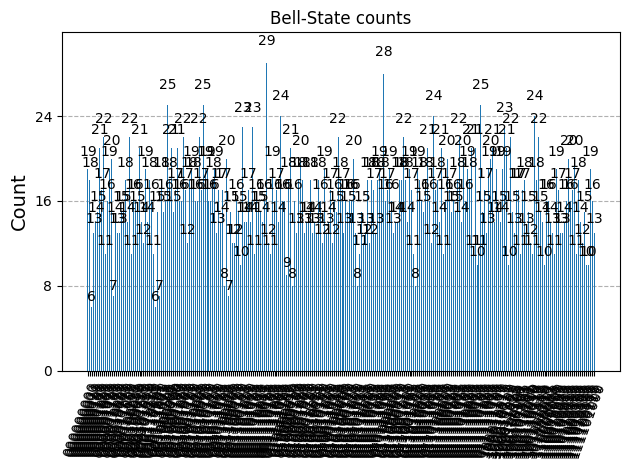

In [27]:
simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ, shots=4096).result()
counts = result.get_counts()
plot_histogram(counts, title='Bell-State counts')

In [28]:
dim = 2**num_bits
edge_img = np.zeros((dim, dim), dtype=int)
for qstate, count in counts.items():

    intensity_bin = qstate[:1]
    y_bin = qstate[1:1 + num_bits]
    x_bin = qstate[1 + num_bits:1 + 2*num_bits]

    intensity = int(intensity_bin,2)
    if intensity == 1:  
        y = int(y_bin, 2)
        x = int(x_bin, 2)

        edge_img[y, x] = intensity
        
print(edge_img)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0]
 [0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0]
 [1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


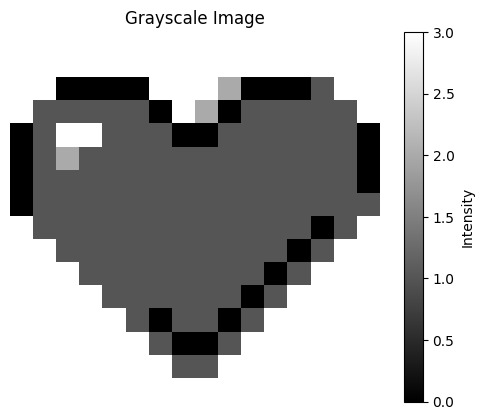

In [29]:
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Grayscale Image')
plt.axis('off')  # Hide axis ticks
plt.show()


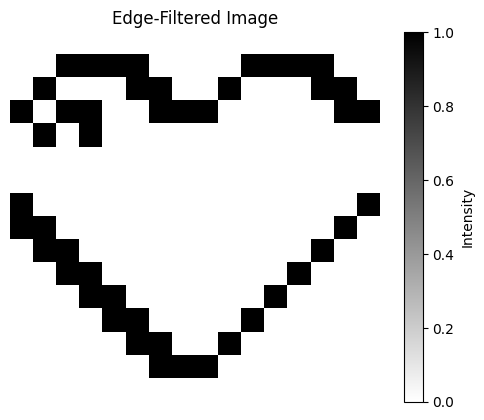

In [30]:
plt.imshow(edge_img, cmap='gray_r', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Edge-Filtered Image')
plt.axis('off')
plt.show()